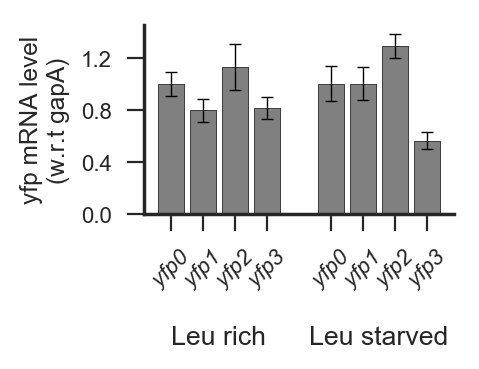

In [4]:
# globals
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import tsem
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

# read raw data
parentdir = '../rawdata/qpcr/mrna_fig1e/'
qpcrfiles = [parentdir + File for File in os.listdir(parentdir)]
data = []
for File in qpcrfiles:
    data.append(pd.read_table(File)[['ct', 'samplename']])
data = pd.concat(data)
data = data[data['samplename'].apply(
    lambda x: (x.find('-RT') == -1) & (x.find('atc') == -1))]
data['ct'] = data['ct'].apply(float)

# normalize by gapA
averagedData = data.groupby('samplename')['ct'].agg([np.mean, tsem])
averagedData['normmean'] = np.nan
averagedData['normtsem'] = np.nan
for row in averagedData.iterrows():
    normsample = row[0].replace('leu1214', 'gapa')
    averagedData.ix[row[0]]['normmean'] = row[1]['mean'] - averagedData.ix[
        normsample]['mean']
    averagedData.ix[row[0]]['normtsem'] = row[1]['tsem'] + averagedData.ix[
        normsample]['tsem']
averagedData = averagedData.select(lambda x: x.find('gapa') == -1)
averagedData.index = map(lambda x: x.replace('_leu1214', ''),
                         averagedData.index)

# convert to abundance units and normalize by yfp0
averagedData['err'] = map(
    lambda x: np.log(2) * x[1]['normtsem'] * 2**(-x[1]['normmean']),
    averagedData.iterrows())
averagedData['mean'] = map(lambda x: 2**(-x[1]['normmean']),
                           averagedData.iterrows())
richsamples = map(lambda x: x.find('rich') != -1, averagedData.index)
starvesamples = map(lambda x: x.find('starve') != -1, averagedData.index)
richnorm = averagedData.ix['3xflagyfp0_rich']['mean']
starvenorm = averagedData.ix['3xflagyfp0_starve']['mean']
averagedData.loc[richsamples, ['mean', 'err']] = averagedData.loc[
    richsamples, ['mean', 'err']] / richnorm
averagedData.loc[starvesamples, ['mean', 'err']] = averagedData.loc[
    starvesamples, ['mean', 'err']] / starvenorm

# re-order for plotting
labels = [
    '3xflagyfp0_rich', '3xflagcta13_rich', '3xflagcta14_rich',
    '3xflagcta1314_rich', '3xflagyfp0_starve', '3xflagcta13_starve',
    '3xflagcta14_starve', '3xflagcta1314_starve'
]
averagedData = averagedData.ix[labels]
# rename tick labels
ticklabels = ['yfp{0}'.format(n) for n in range(4)] * 2

# plot fig.1e
fig = plt.figure()
fig.clf()
ax = fig.add_subplot(1, 1, 1)
# leave space between rich and starved samples
x = range(0, len(averagedData) / 2) + range(
    len(averagedData) / 2 + 1, len(averagedData) + 1)
y = averagedData['mean']
err = averagedData['err']
ax.bar(x, y, facecolor='grey', edgecolor='black')
ax.errorbar(
    x,
    y,
    err,
    elinewidth=0.5,
    color='black',
    capsize=2,
    capthick=0.5,
    linestyle='None')
ax.set(ylabel='yfp mRNA level\n(w.r.t gapA)')
ax.text(1.5, -1, 'Leu rich', ha='center')
ax.text(6.5, -1, 'Leu starved', ha='center')
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 1.25, 0.4))
sns.despine()
ax.set_xticklabels(
    ticklabels, rotation=45, ha='center', va='top', fontstyle='italic')
fig.set_size_inches([2, 1.25])
fig.savefig('../figures/fig1e.svg')